initializations <--

In [1]:
from pickle import TRUE

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# for regression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statistics import mean
import subprocess # from mdbtools

stats_mdb = "stats.mdb"
tables = subprocess.check_output(["mdb-tables", stats_mdb]).decode().split()

# exploratory table name inquiry
print(tables) # Amber is an online conversion tool default

['Amber']


## Problem Statement
### 3.b
Everyone loves a shiny new toy, and baseball GMs are no different.  But is there a material benefit to throwing all your eggs in a young-kid-basket?  The data is set up to test the hypothesis--are younger players better?  Or asked another way: What is a baseball player's prime age?  The response variable will be wOBA which stands for weighted on-base average.  This is an advanced statistic based on linear weights designed to measure a player's overall offensive contributions per plate appearance.  The weights are based on observed run values for individual events, league-wide, and vary year to year.  The data was taken from baseballsavant.mlb.com, exported to .csv, converted online to .mdb, and assuaged in the notebook.

In [2]:
stats_table = "Amber"

def convert_mdb2df(file, table) -> pd.DataFrame:
    d = subprocess.check_output(["mdb-export", file, table]).decode().split("\n")
    # first row has arbitrary letter designators, 2nd row has column names
    # online conversion added extraneous string characters that needed to be removed
    columns = d[1].replace('"', '').split(',')
    data = [i.replace('"', '').split(',') for i in d[2:]] # data starts in row 3
    df = pd.DataFrame(columns=columns, data=data)
    return df

df = convert_mdb2df(file=stats_mdb, table=stats_table).dropna(axis=0)

# df.columns


All data decodes as string, need to convert number columns appropriately

In [3]:
# required to recast object types

df.player_age = df.player_age.astype(int)

df[["slg_percent", "on_base_percent", "woba", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"]] = df[["slg_percent", "on_base_percent", "woba", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"]].astype(float)
print(df.dtypes)

last_name              object
first_name             object
player_id              object
year                   object
player_age              int64
slg_percent           float64
on_base_percent       float64
woba                  float64
exit_velocity_avg     float64
barrel_batted_rate    float64
hard_hit_percent      float64
dtype: object


## Data Understanding & Figures
### 2.a

In [4]:
df.sort_values(by=['woba'], ascending=False).head()

,last_name,first_name,player_id,year,player_age,slg_percent,on_base_percent,woba,exit_velocity_avg,barrel_batted_rate,hard_hit_percent
626,Soto,Juan,665742,2020,21,0.695,0.490,0.478,92.1,18.3,51.6
256,Harper,Bryce,547180,2015,22,0.649,0.460,0.461,91.4,12.9,47.5
732,Judge,Aaron,592450,2022,30,0.686,0.422,0.458,95.9,26.5,61.8
559,Freeman,Freddie,518692,2020,30,0.640,0.462,0.456,92.4,14.7,54.2
110,Betts,Mookie,605141,2018,25,0.640,0.438,0.449,92.2,14.1,50.6


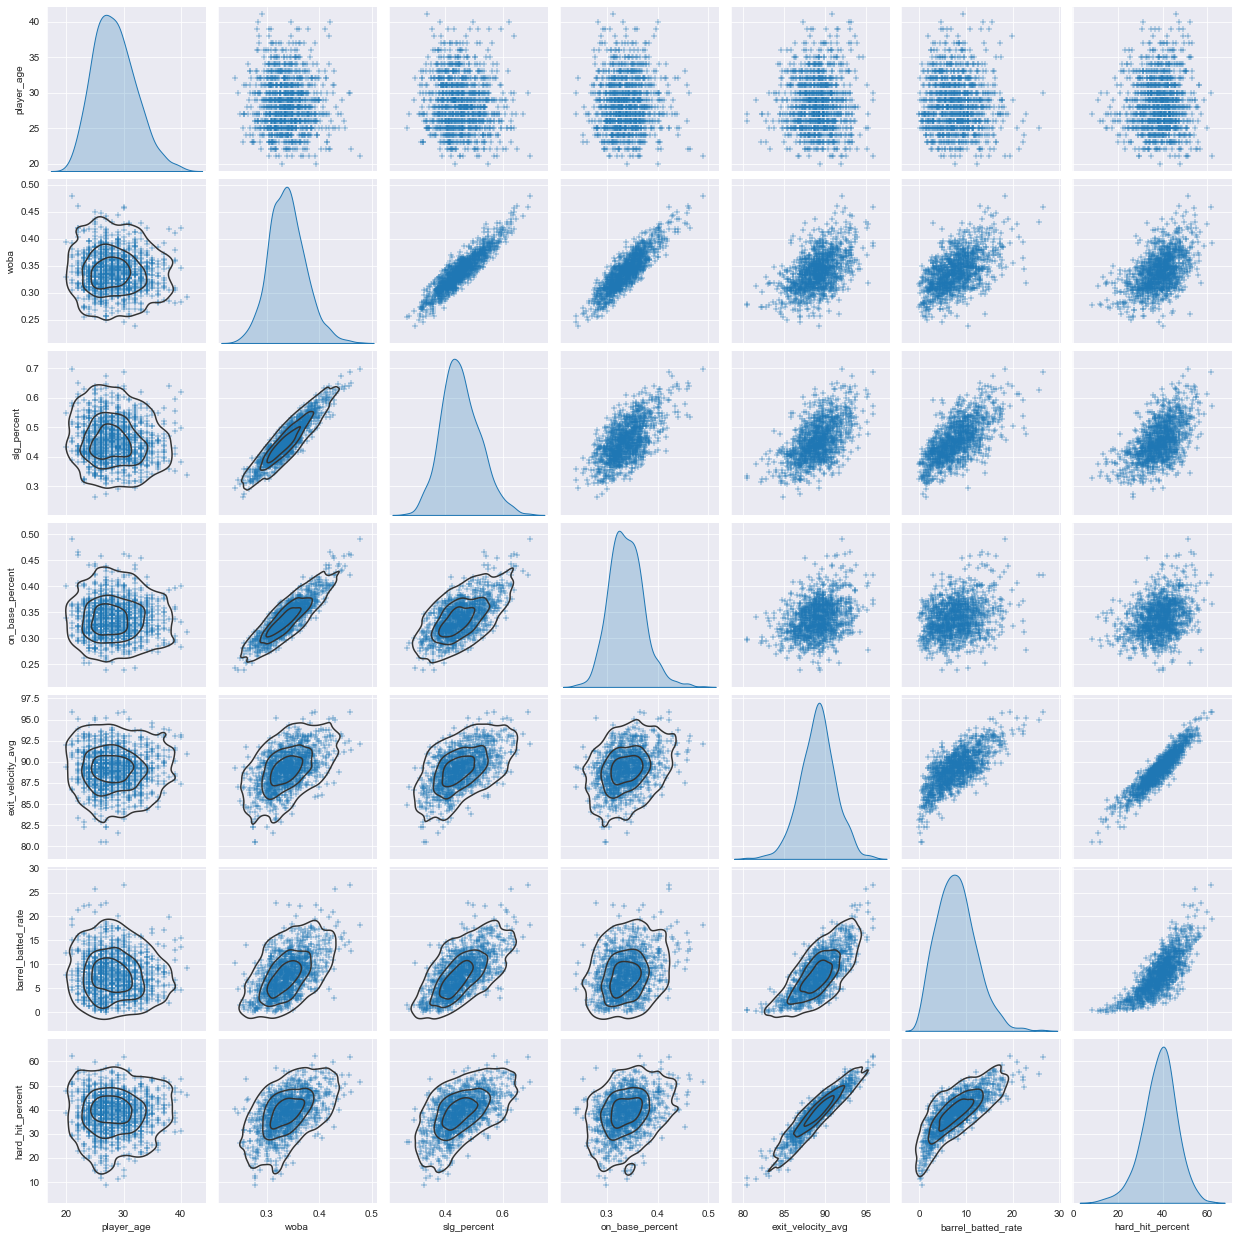

In [5]:
g = sns.pairplot(data=df, vars=["player_age", "woba", "slg_percent", "on_base_percent", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"], diag_kind="kde", markers="+")
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

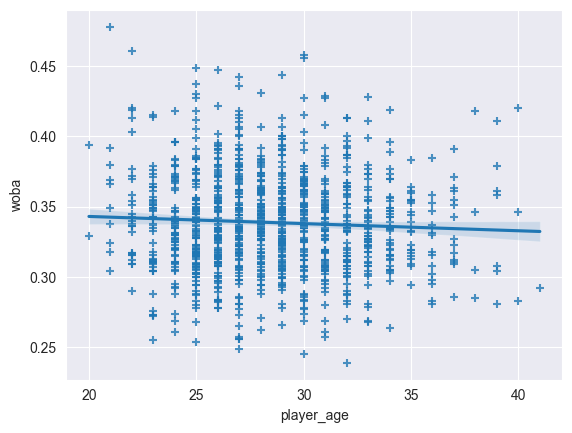

In [6]:
sns.regplot(x=df.player_age, y=df.woba, marker="+")
plt.show()

## Full Model
### 2.b

In [7]:
from sklearn.preprocessing import StandardScaler

X = df[["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"]]
X = StandardScaler().fit_transform(X)  # this produces the same adj r2, just different coefficients
X = pd.DataFrame(X, columns=["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"])
y = df.woba
X = add_constant(X)

model = sm.OLS(endog=y, exog=X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   woba   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     133.3
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.38e-93
Time:                        17:18:11   Log-Likelihood:                 2379.7
No. Observations:                1112   AIC:                            -4749.
Df Residuals:                    1107   BIC:                            -4724.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3388      0

## p-test selection
### 2.c
i. In a code comment, mention your criteria for selecting the best p-test model.
ii. Display a model summary of the best p-test model.

In [8]:
# hard_hit_percent and player_age will be dropped due to p > 0.05
X.drop(columns=["hard_hit_percent", "player_age"], inplace=True)  # dropping hard_hit_percent does not change adj r2, dropping player_age does not change

model = sm.OLS(endog=y, exog=X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   woba   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     265.4
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.30e-95
Time:                        17:18:11   Log-Likelihood:                 2378.5
No. Observations:                1112   AIC:                            -4751.
Df Residuals:                    1109   BIC:                            -4736.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3388      0

## AIC Selection
### 2.d
i. Use the “AIC Analysis” code to find the best model using AIC.
ii. Display a model summary of the best AIC model.

In [9]:
###  Build Every Possible Model
from itertools import chain, combinations

X = df[["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"]]
X = StandardScaler().fit_transform(X)  # this produces the same adj r2, just different coefficients
X = pd.DataFrame(X, columns=["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"])
y = df.woba
X = add_constant(X)

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(1, len(s)+1))

mylist = list(powerset(list(X.columns)))
mylist = [list(row) for row in mylist]

# print(mylist)

##Target is AIC
AIC_scores = pd.DataFrame(columns=["AIC"])

for i in range(len(mylist)):
    AIC_scores.loc[i,'AIC'] = sm.OLS(y,X[mylist[i]]).fit().aic

print(AIC_scores.sort_values(by='AIC').head())
print("---------------------------------------------------------------")
# print(mylist[25])  # best score
# print(mylist[18])  # is worth nothing the 2nd best AIC is the same model generated from p-test model
X = X[mylist[25]]  # filter X to only include lowest AIC score features

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

            AIC
25 -4751.275854
18 -4751.026026
30  -4749.31956
28 -4749.106714
27 -4738.984178
---------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   woba   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     177.9
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.79e-94
Time:                        17:18:11   Log-Likelihood:                 2379.6
No. Observations:                1112   AIC:                            -4751.
Df Residuals:                    1108   BIC:                            -4731.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          

## RFE
### 2.e
i. In a code comment, mention your criteria for selecting the best RFE model.
ii. Display a model summary of the best RFE model.

In [11]:
from sklearn.feature_selection import RFE
import sklearn.linear_model as lmod

model = lmod.LinearRegression()

# reset features
X = df[["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"]]
X = StandardScaler().fit_transform(X)  # this produces the same adj r2, just different coefficients
X = pd.DataFrame(X, columns=["player_age", "exit_velocity_avg", "barrel_batted_rate", "hard_hit_percent"])  # convert back to DataFrame from np.array
X = add_constant(X)
print("\nSearch the best k features for k = 1 to 5\n")

for k in range(1, 5):
    rfe = RFE(estimator=model, n_features_to_select=k)

    fit = rfe.fit(X, y)

    f = fit.get_support(1) #the most important features

    # final_features = data[data.columns[f]] # final features: this gives wrong results
    final_features = X[X.columns[f]] # final features

    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: %s" % final_features.columns)
    print("Score: %2.2f" % fit.score(X, y))
    print("----------")


Search the best k features for k = 1 to 5

Num Features: 1
Selected Features: Index(['barrel_batted_rate'], dtype='object')
Score: 0.30
----------
Num Features: 2
Selected Features: Index(['exit_velocity_avg', 'barrel_batted_rate'], dtype='object')
Score: 0.32
----------
Num Features: 3
Selected Features: Index(['player_age', 'exit_velocity_avg', 'barrel_batted_rate'], dtype='object')
Score: 0.33
----------
Num Features: 4
Selected Features: Index(['player_age', 'exit_velocity_avg', 'barrel_batted_rate',
       'hard_hit_percent'],
      dtype='object')
Score: 0.33
----------


## Modeling Evaluation
### 3.c
One observation that stood out after generating a "data understanding graph" using seaborn's regression plot was that linear regression probably isn't the best tool for the given hypothesis.  That is to say, a line only has one slope; players get better as they get older or worse (based on the limitations of a line).  A line rules out the possibility of mid-career players being the "best."  The feature "player_age" was interestingly not that weak of a feature based on the p-test value (0.13) and can still suggest younger players are better.  A possible better methodology would be to group tight age ranges (e.g., 20-23, 24-26) and turn this into a classification model.  The backward-selection/p-test value methodology generated the same model as the second-best AIC score model.  The most satisfying process is RFE because it shows the ideal number of features at a glance.  Still, the analyst should determine these models using all the tools possible, meaning each method can help converge on the perfect solution.  Another interesting observation was that the model performance was the same regardless of Standardized features.  The coefficients changed, but the p-test and model r2 did not.  Having age and barrel_rate in the same feature set would suggest improper weights, but this did not happen.